# LDA Analysis

In [11]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [12]:
debate_files = ['../experiment_2_data/dem_2016_results.csv', '../experiment_2_data/rep_2016_results.csv', '../experiment_2_data/dem_1976_results.csv', '../experiment_2_data/rep_1976_results.csv']
dfs = [pd.read_csv(file) for file in debate_files]

In [13]:
#lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.add('uh')
stop_words.add('im')

# preprocess
def preprocess(text):
    text = re.sub(r'[^a-z\s]', '', text.lower()) 
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)

texts_per_debate = []
for df in dfs:
    df['cleaned_response'] = df['Model_Response'].apply(preprocess)
    texts_per_debate.append(df['cleaned_response'].tolist())

# vectorize combined data
combined_texts = [text for debate_texts in texts_per_debate for text in debate_texts]
vectorizer = CountVectorizer(stop_words=list(stop_words))
combined_doc_term_matrix = vectorizer.fit_transform(combined_texts)


In [14]:
# set topics to 14
num_topics = 14

#fit LDA model
lda_combined = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_combined.fit(combined_doc_term_matrix)


LatentDirichletAllocation(n_components=14, random_state=42)

In [15]:
#display top 10 words for each topic 

feature_names = vectorizer.get_feature_names_out()
topics_combined = []
for topic_idx, topic in enumerate(lda_combined.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10:-1]] 
    topics_combined.append(top_words)

for i, topic in enumerate(topics_combined):
    print(f"Topic {i + 1}: {', '.join(topic)}")


Topic 1: health, people, one, care, would, program, think, thing, year
Topic 2: country, people, thats, president, used, take, way, law, inflation
Topic 3: right, american, people, opportunity, black, civil, minority, woman, year
Topic 4: going, job, inflation, make, country, people, million, new, sure
Topic 5: going, year, problem, country, america, budget, well, billion, president
Topic 6: government, health, care, trust, american, job, mr, well, restore
Topic 7: black, environmental, american, administration, sustainability, thats, time, seen, life
Topic 8: education, school, uhh, would, year, program, federal, budget, one
Topic 9: people, american, government, know, think, year, believe, state, country
Topic 10: people, america, country, job, many, come, think, back, say
Topic 11: bill, education, dont, people, let, school, year, college, need
Topic 12: president, job, people, one, year, would, thing, country, say
Topic 13: people, think, thats, well, wh, going, policy, make, one
T

In [16]:
#calculate topic distributions
topic_distributions_per_debate = [
    lda_combined.transform(vectorizer.transform(df['cleaned_response']))
    for df in dfs
]

avg_topic_distributions = [np.mean(td, axis=0) for td in topic_distributions_per_debate]

topic_distribution_df = pd.DataFrame(avg_topic_distributions,
                                      columns=[f"Topic {i+1}" for i in range(num_topics)],
                                      index=['Dem 2016-2024', 'Rep 2016-2024', 'Dem 1976-1984', 'Rep 1976-1984'])



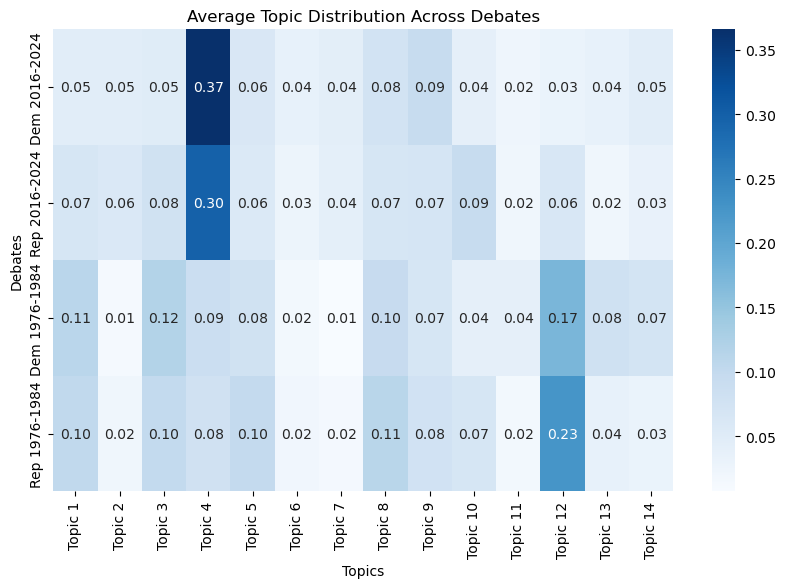

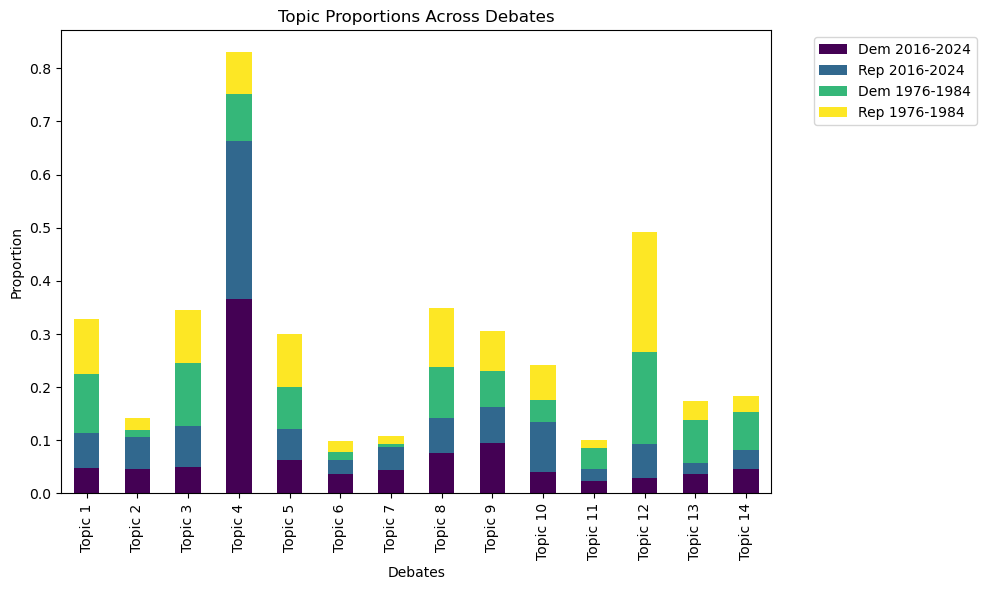

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(topic_distribution_df, annot=True, cmap='Blues', fmt='.2f')
plt.title('Average Topic Distribution Across Debates')
plt.xlabel('Topics')
plt.ylabel('Debates')
plt.show()

topic_distribution_df.T.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Topic Proportions Across Debates')
plt.ylabel('Proportion')
plt.xlabel('Debates')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



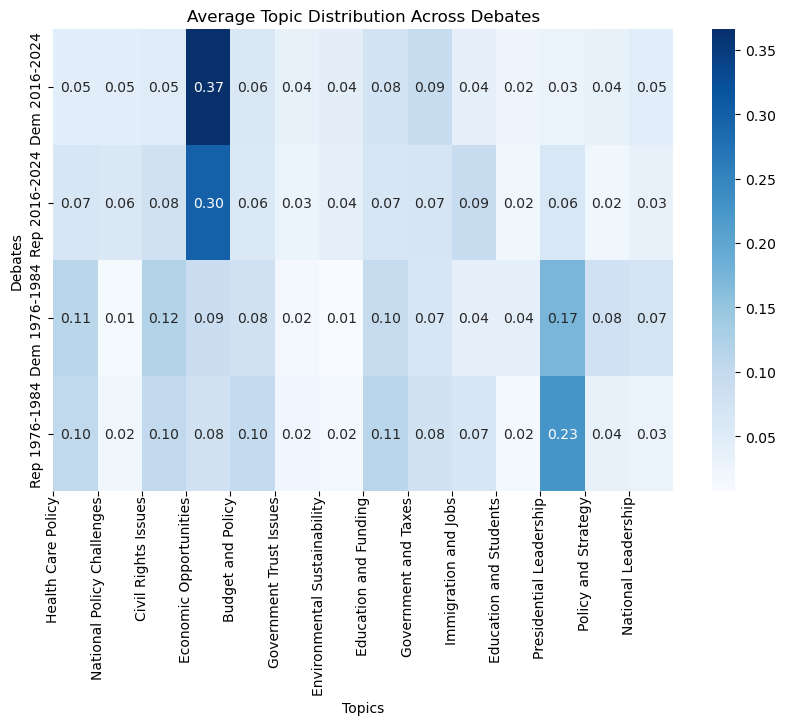

In [18]:
topic_labels = [
    'Health Care Policy', 'National Policy Challenges', 'Civil Rights Issues', 
    'Economic Opportunities', 'Budget and Policy', 'Government Trust Issues', 
    'Environmental Sustainability', 'Education and Funding', 'Government and Taxes', 
    'Immigration and Jobs', 'Education and Students', 'Presidential Leadership', 
    'Policy and Strategy', 'National Leadership'
]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(topic_distribution_df, annot=True, cmap='Blues', fmt='.2f')

plt.title('Average Topic Distribution Across Debates')
plt.xlabel('Topics')
plt.ylabel('Debates')
ax.set_xticks(range(len(topic_labels)))  
ax.set_xticklabels(topic_labels, rotation=90, ha='center', va='center_baseline')
plt.show()


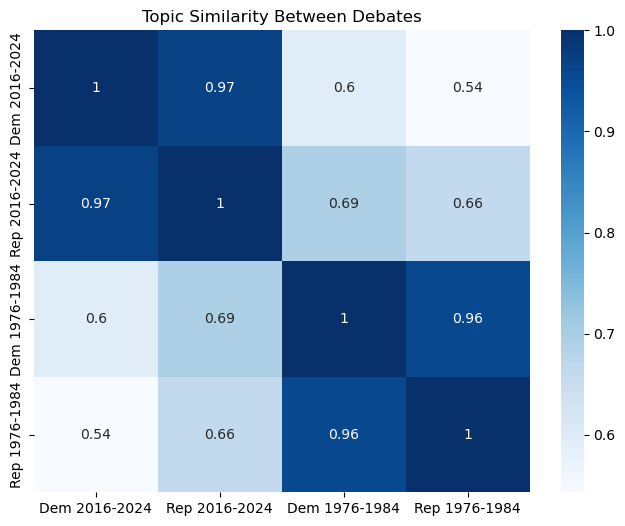

In [19]:

# cosine similarity of topic distributions
similarity_matrix = cosine_similarity(topic_distribution_df)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap='Blues', xticklabels=topic_distribution_df.index, yticklabels=topic_distribution_df.index)
plt.title('Topic Similarity Between Debates')
plt.show()


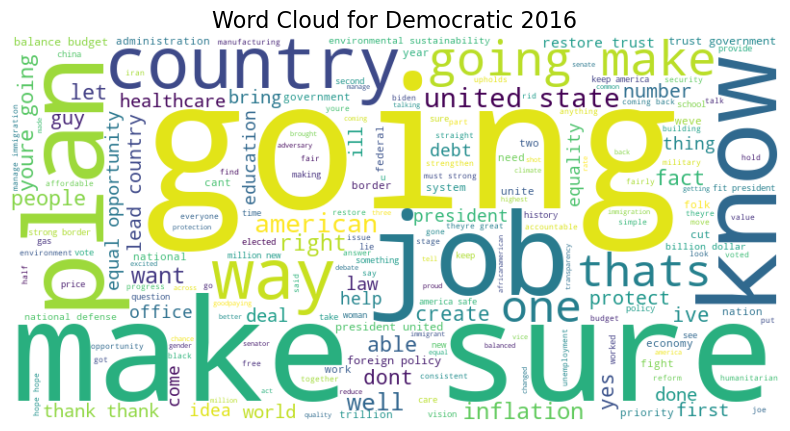

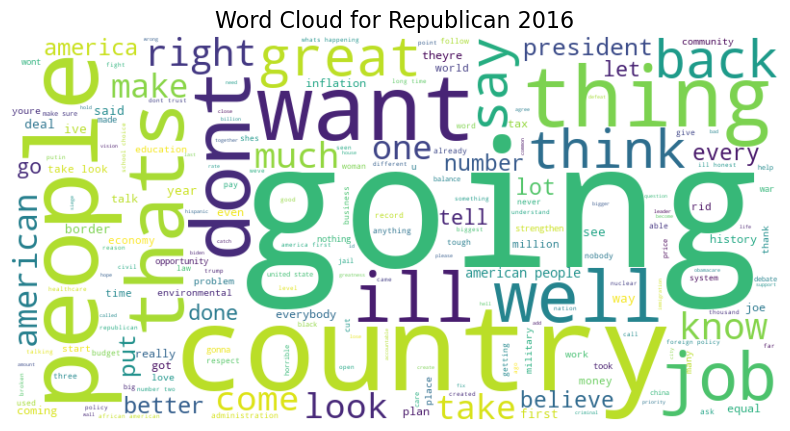

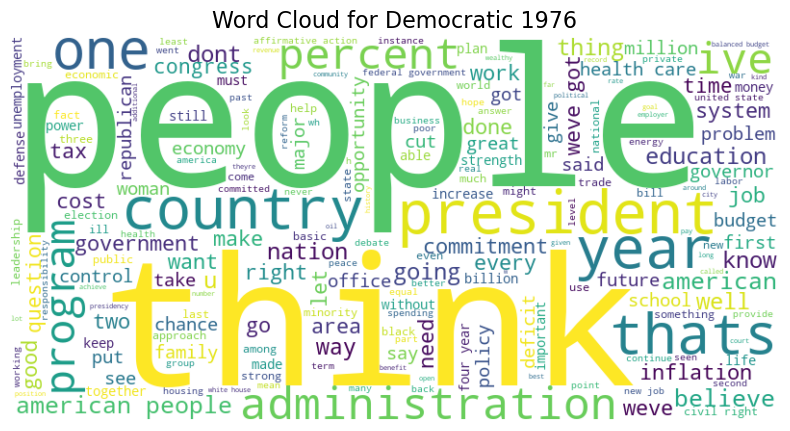

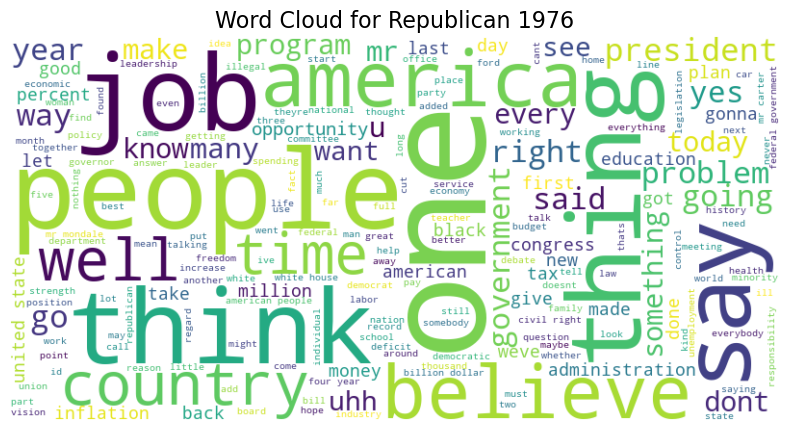

In [20]:

# create word clouds for each debate 
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

debate_titles = ['Democratic 2016', 'Republican 2016', 'Democratic 1976', 'Republican 1976']

for i, df in enumerate(dfs):
    combined_text = ' '.join(df['cleaned_response'])
    plot_wordcloud(combined_text, title=f"Word Cloud for {debate_titles[i]}")
